# **CNN Cancer Detection Mini-Project**

In [2]:
#! pip install plotnine
#! pip install seaborn
#!pip install plotly
#!pip install scikit-image
import numpy as np 
import pandas as pd
import os 
import random
from sklearn.utils import shuffle 
import shutil 
from plotnine import * 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.transform import rotate 
from skimage import io
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam





In [3]:
tf.__version__

'2.15.0'

In [4]:
# Read in data 

test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
df_train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [5]:
df_train.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [6]:
df_train.describe()

label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [8]:
print(f"Number of training images:{len(os.listdir(train_path))}")
print(f"Number of test set images:{len(os.listdir(test_path))}")

Number of training images:220025
Number of test set images:57458


## **Step 1: Brief Description of the problem and data**

In this project, the challenge is identifying whether or not a histopathologic image contains at least one pixel of tumor tissue. 

The training data contains 220025 images. Each of the training images has an `id` and a `label`. The test set contains 57,458 images. 

## **Step 2: Exploratory Data Analysis - Inspect, Visualize, and Clean the Data** 

In [9]:
df_train["label"].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 31'. Pick better value with 'binwidth'.


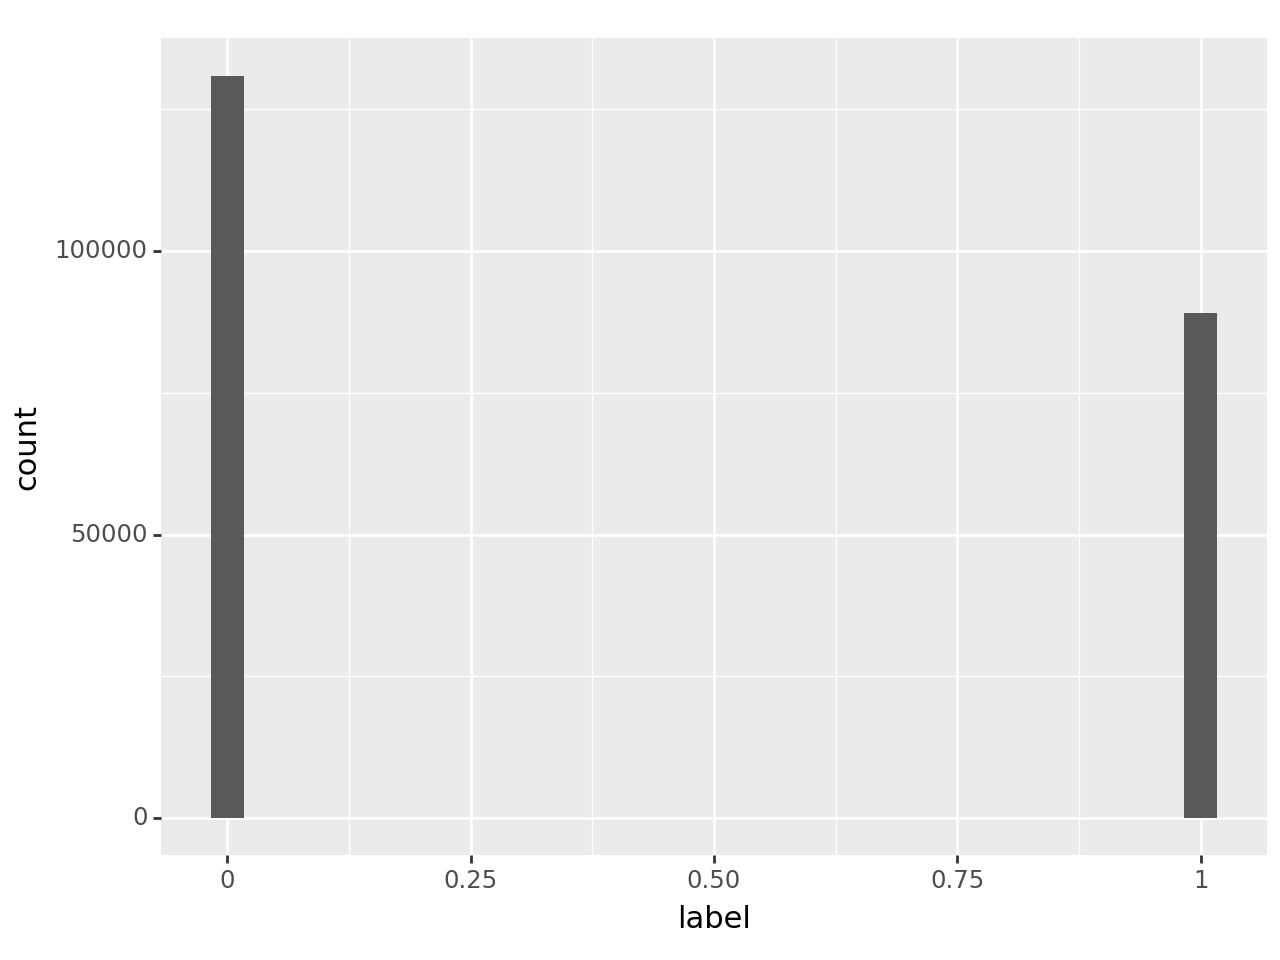

<Figure Size: (640 x 480)>

In [10]:
# Histogram of the labels 

ggplot(df_train) + geom_histogram(aes(x = "label"))

I'm a big fan of ggplot, so the above histogram was made with the plotnine package, as I've been wanting to try out this package to make ggplot graphics in python. From the above histogram and the value counts, we can see that a larger number of the images are classified as non-metastatic (n=130908), and a smaller number are labeled as metastatic (n = 89117)

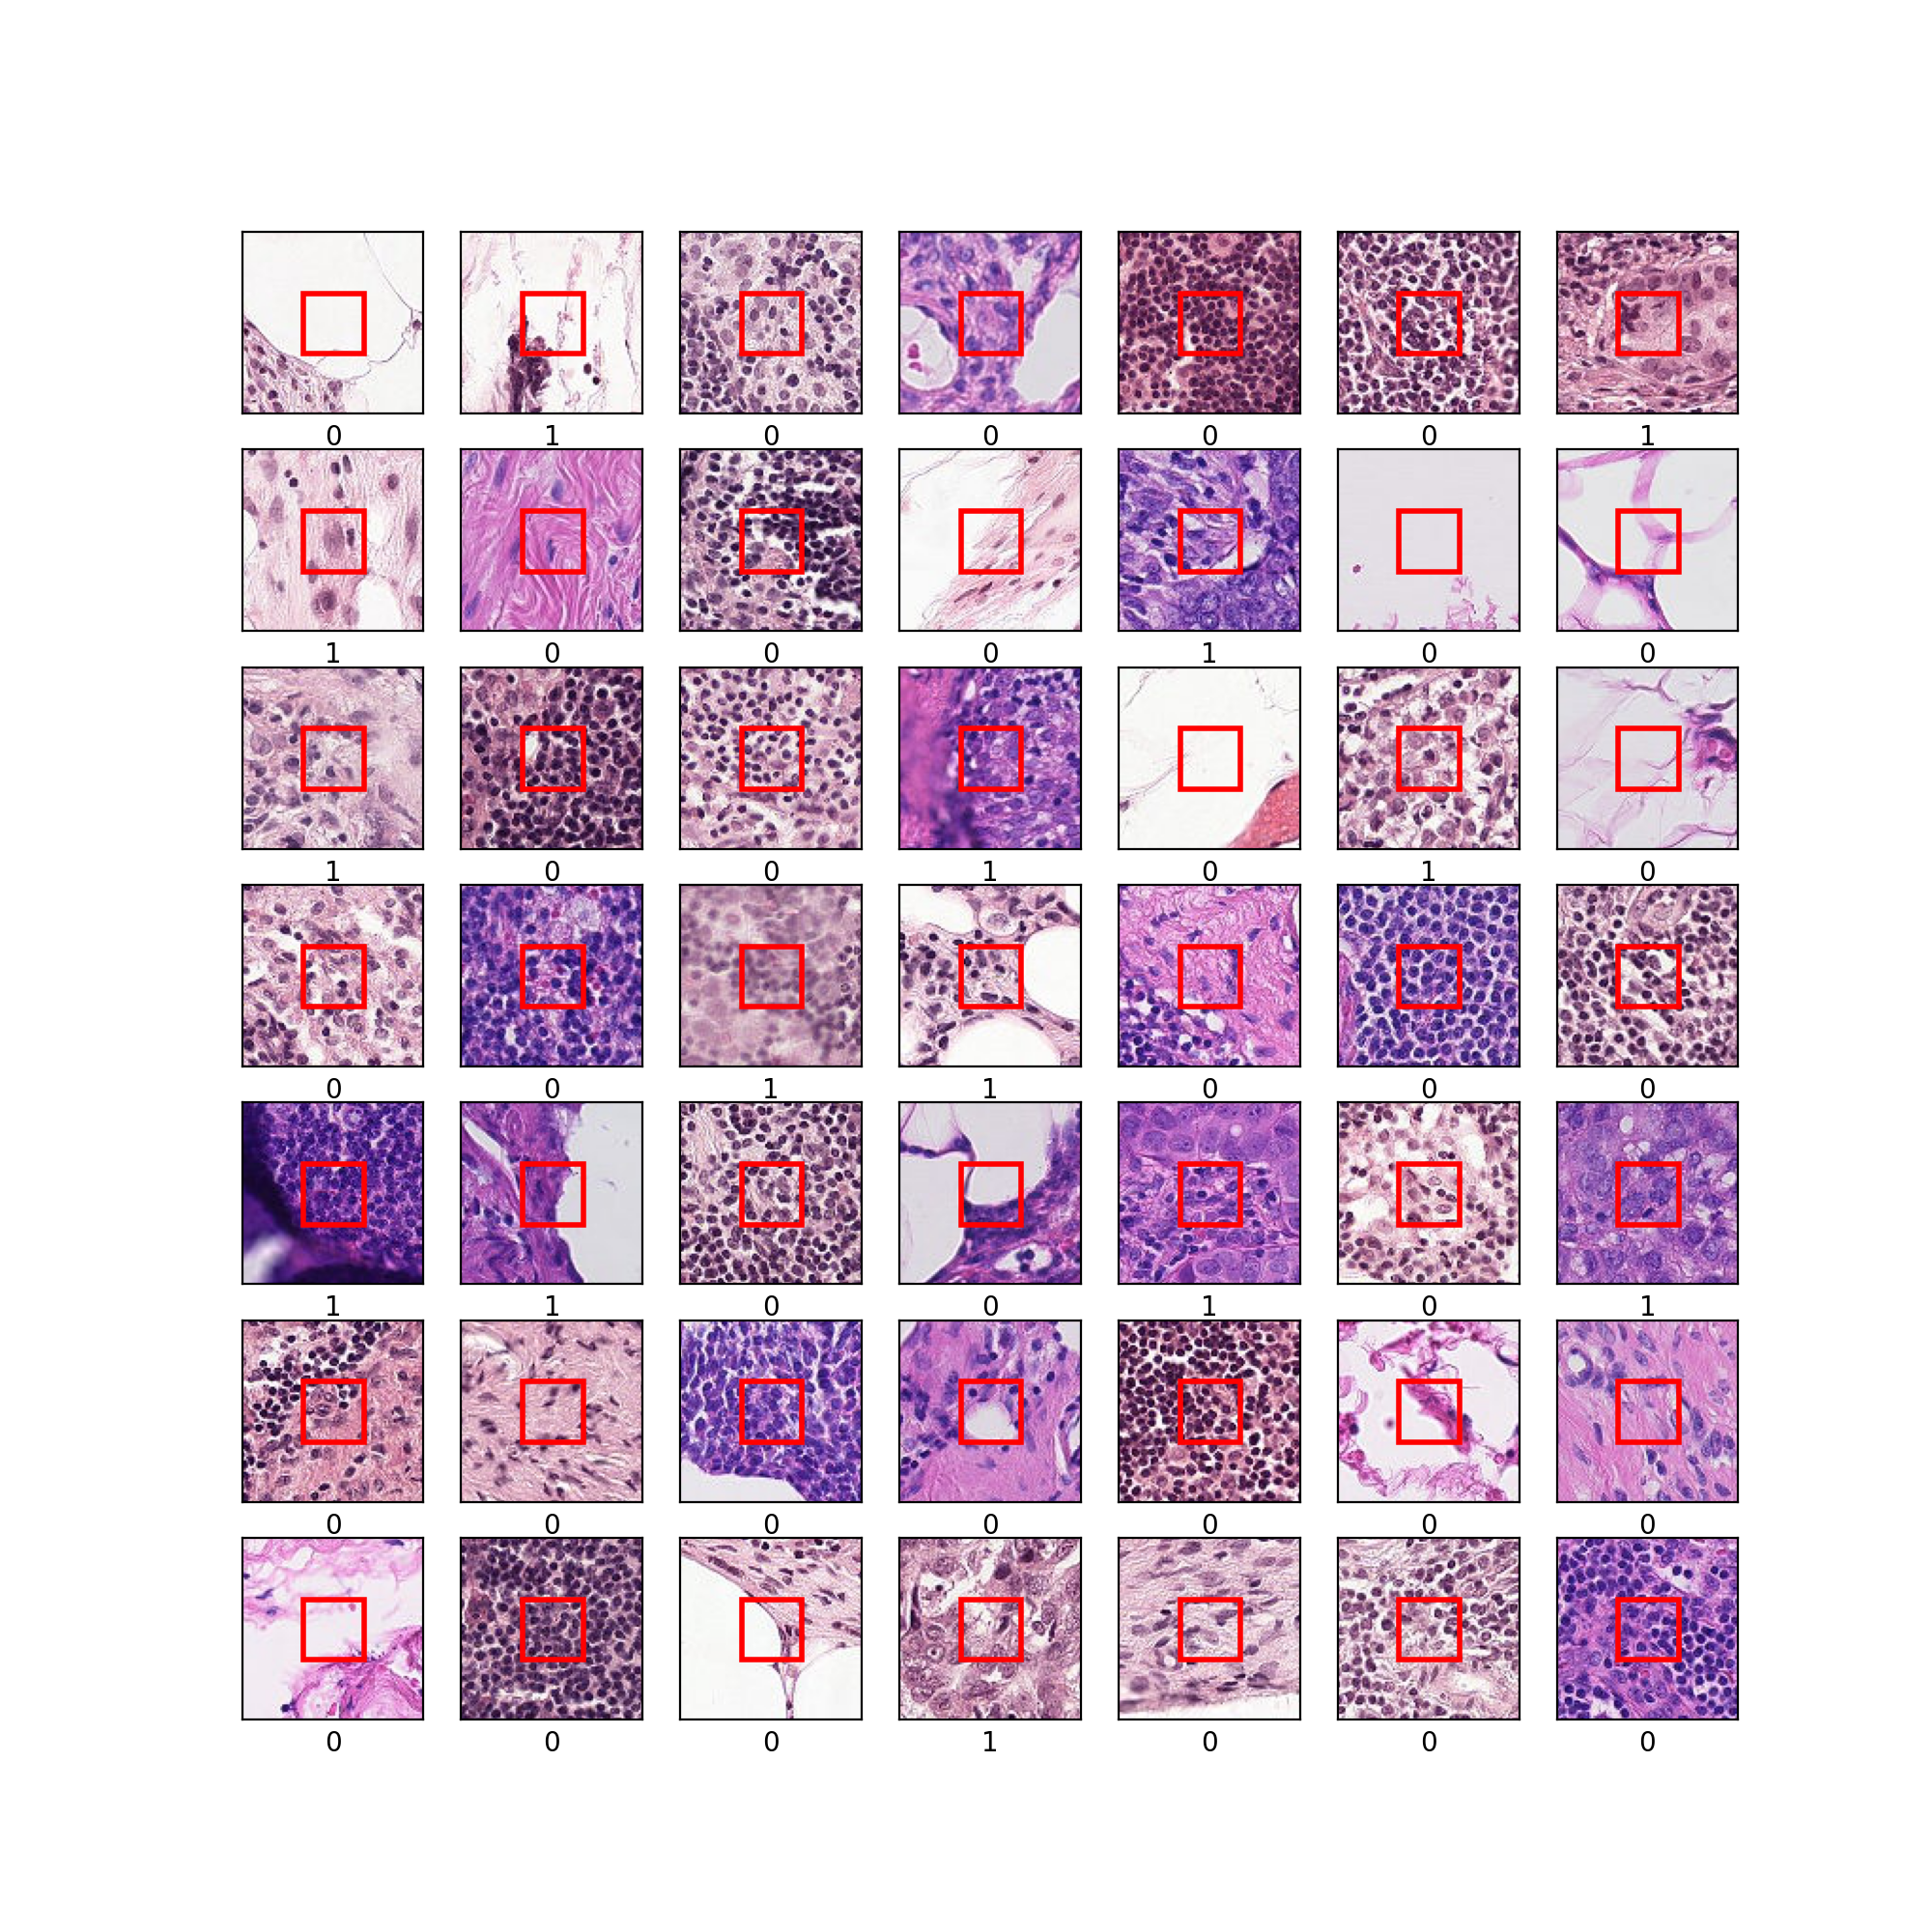

In [11]:
fig, ax = plt.subplots(7, 7, figsize=(10, 10))


for i, axis in enumerate(ax.flat):
    file = str(train_path + df_train.id[i] + '.tif')
    image = io.imread(file)
    axis.imshow(image)
    box = patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='r',facecolor='none', linestyle='-')
    axis.add_patch(box)
    axis.set(xticks=[], yticks=[], xlabel = df_train.label[i]);
    
plt.show()

Above are 49 images from the training data set showing both slides classified as metastatic and benign.

### Description of data cleaning procedures and plan for analysis

There was really no data cleaning required for this dataset. There were no missing values to handle and no other obvious issues with data cleanliness. 

In terms of a plan for analysis, we just need to normalize the images, perform a test/train split, and train the models. 

## **Step 3: Describe Model Architecture**

For this project, I plan to create 2 different models to compare the effects of tuning different hyperparameters. 

Since the data is binary, a sigmoid activation layer will be the most appropriate. To keep things simple, in the first model I will not tune any hyperparameters. The archicture will be an input layer followed by 2 convolutional layers, which will be followed by a MaxPool layer. This will be repeated n times. For this project, I will use an n of 2, but given unlimited time, this could be scaled higher if needed. I will train with 10 epochs.  



In [12]:
def add_tif_ext(filename):
    return filename+".tif"

df_train["id"] = df_train["id"].apply(add_tif_ext)
df_train["label"] = df_train["label"].astype(str)



In [13]:
df_train.head()

id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0

In [14]:
df_train.shape

(220025, 2)

In [15]:
# Setting a random state for reproducibility 
RANDOM_STATE = 11



In [17]:
# Going with a larger batch size here for efficiency. With unlimited time, could consider reducing this. 

BATCH_SIZE = 256

In [18]:
df_train = shuffle(df_train, random_state=RANDOM_STATE)

In [19]:
data_generator = ImageDataGenerator(rescale = 1./255., validation_split=0.15)

In [20]:
tpu = None

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [21]:
training_data_generator = data_generator.flow_from_dataframe(
dataframe = df_train, 
directory = train_path,
x_col = "id",
y_col = "label",
subset = "training",
batch_size = BATCH_SIZE,
seed = RANDOM_STATE,
class_mode = "binary",
target_size = (64, 64))

Found 187022 validated image filenames belonging to 2 classes.


In [22]:
validation_data_generator = data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = train_path,
    x_col = "id",
    y_col = "label",
    subset = "validation",
    batch_size = BATCH_SIZE,
    seed = RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64)) 

Found 33003 validated image filenames belonging to 2 classes.


In [23]:
ROC_1 = tf.keras.metrics.AUC()


with strategy.scope():
    
    #create model
    model_one = Sequential()
    
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(MaxPooling2D(pool_size=(2,2)))

    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(AveragePooling2D(pool_size=(2,2)))

    model_one.add(Flatten())
    model_one.add(Dense(1, activation='sigmoid'))

    model_one.build(input_shape=(BATCH_SIZE, 64, 64, 3))        
    
    model_one.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])
    

model_one.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 62, 62, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2  (256, 30, 30, 16)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (256, 28, 28, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (256, 26, 26, 32)         9248      
                                                                 
 average_pooling2d (Average  (256, 13, 13, 32)         0         
 Pooling2D)                                             

In [24]:
EPOCHS = 10

history_model_one = model_one.fit(
                        training_data_generator,
                        epochs = EPOCHS,
                        validation_data = validation_data_generator)

Epoch 1/10


I0000 00:00:1708195949.585273     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


731/731 [==============================] - 1852s 3s/step - loss: 0.6095 - accuracy: 0.6813 - auc: 0.7219 - val_loss: 0.5415 - val_accuracy: 0.7371 - val_auc: 0.8069
Epoch 2/10
731/731 [==============================] - 417s 571ms/step - loss: 0.5445 - accuracy: 0.7365 - auc: 0.7926 - val_loss: 0.5206 - val_accuracy: 0.7520 - val_auc: 0.8287
Epoch 3/10
731/731 [==============================] - 286s 392ms/step - loss: 0.5158 - accuracy: 0.7572 - auc: 0.8185 - val_loss: 0.4847 - val_accuracy: 0.7772 - val_auc: 0.8478
Epoch 4/10
731/731 [==============================] - 283s 387ms/step - loss: 0.4976 - accuracy: 0.7679 - auc: 0.8325 - val_loss: 0.4957 - val_accuracy: 0.7611 - val_auc: 0.8546
Epoch 5/10
731/731 [==============================] - 280s 383ms/step - loss: 0.4841 - accuracy: 0.7759 - auc: 0.8418 - val_loss: 0.4929 - val_accuracy: 0.7724 - val_auc: 0.8546
Epoch 6/10
731/731 [==============================] - 279s 382ms/step - loss: 0.4719 - accuracy: 0.7834 - auc: 0.8503 - val

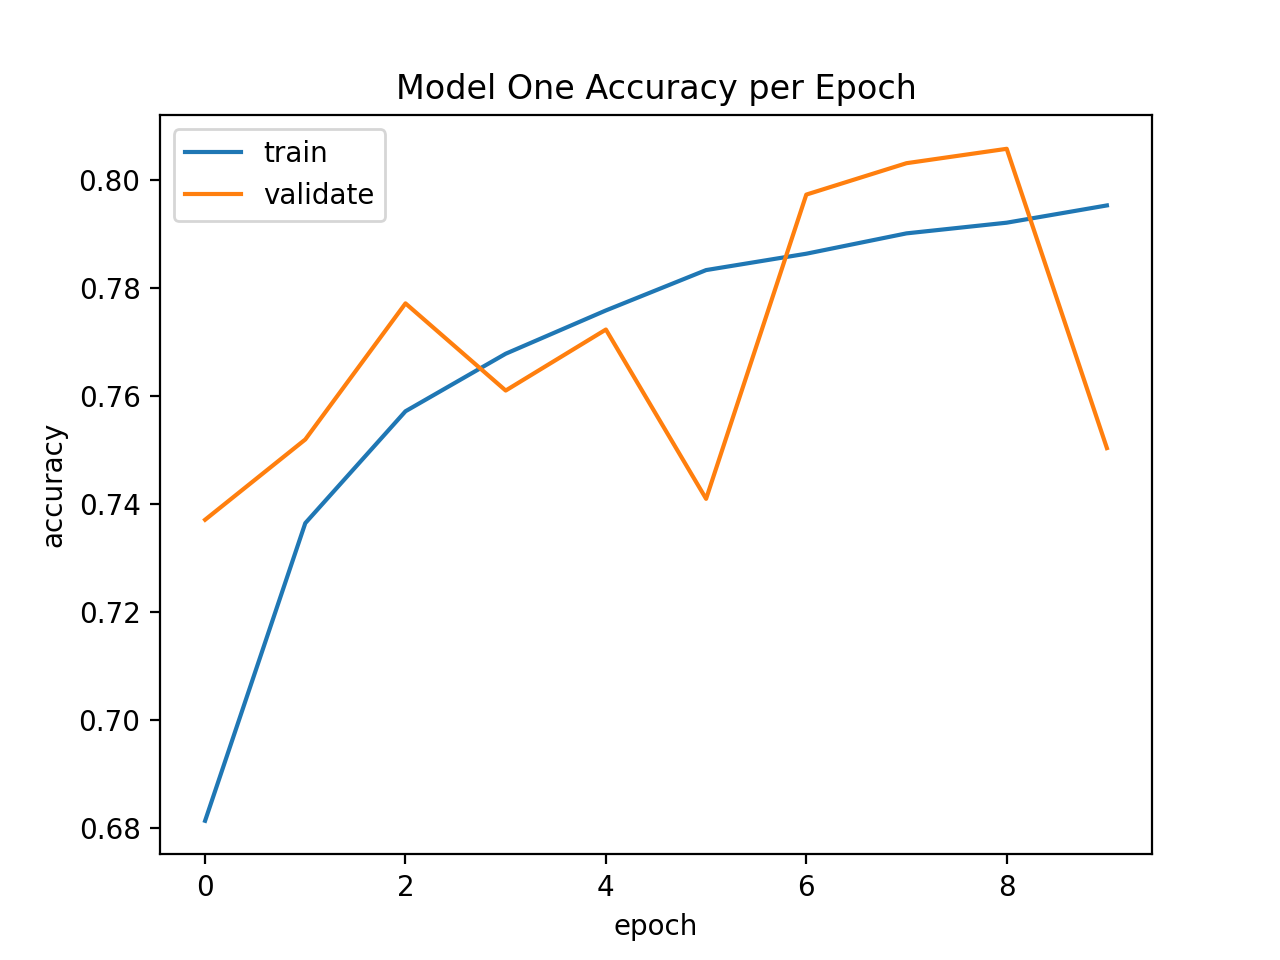

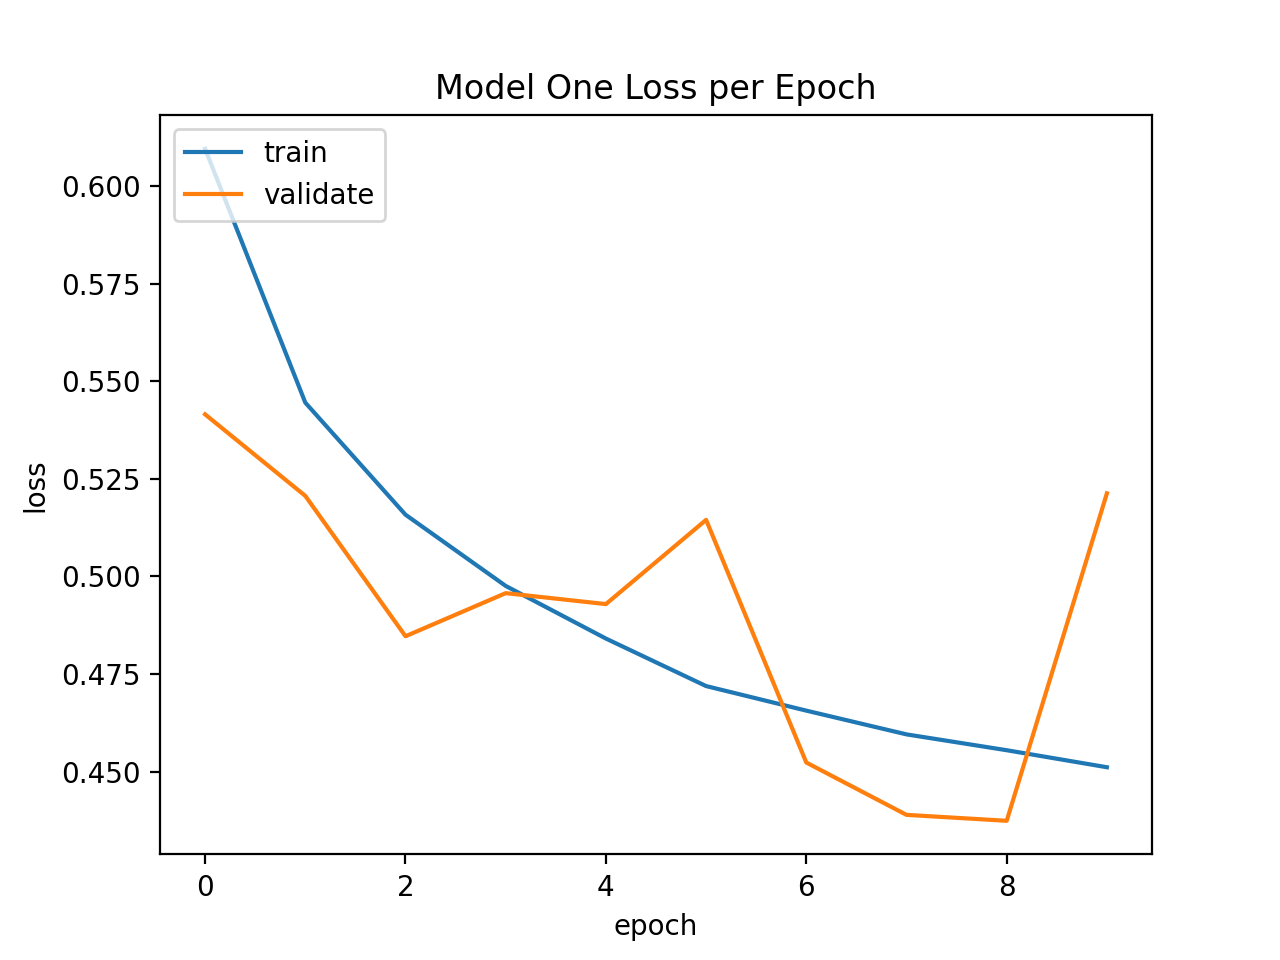

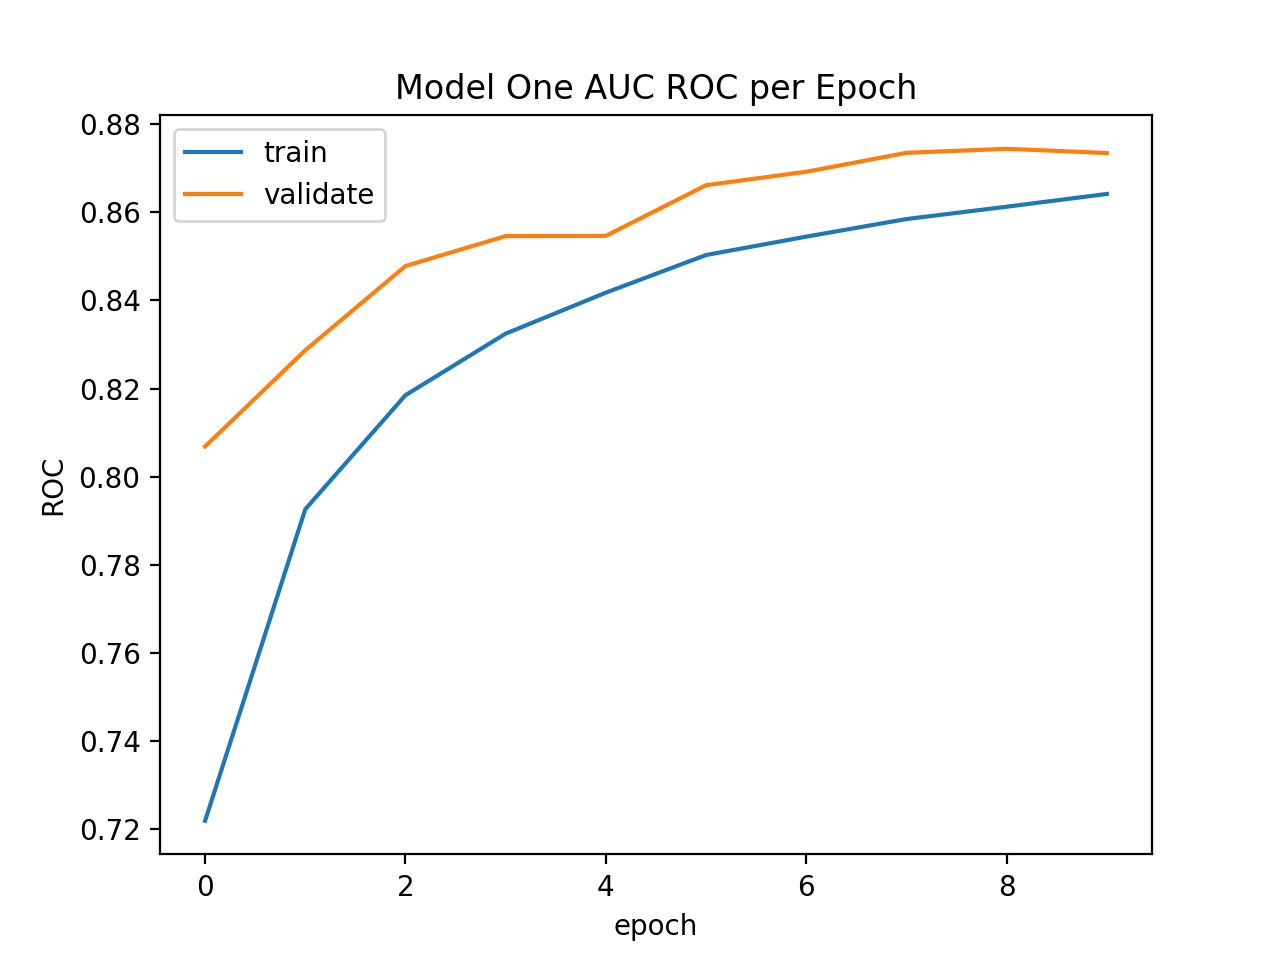

In [25]:
plt.plot(history_model_one.history['accuracy'])
plt.plot(history_model_one.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model_one.history['loss'])
plt.plot(history_model_one.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model_one.history['auc'])
plt.plot(history_model_one.history['val_auc'])
plt.title('Model One AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

### Model 2

In [57]:
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    model_two = Sequential()
    
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model_two.add(MaxPooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(AveragePooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Flatten())
    model_two.add(Dense(1, activation='sigmoid'))
    
    model_two.build(input_shape=(BATCH_SIZE, 64, 64, 3))        
    
    
    adam_optimizer = Adam(learning_rate=0.0001)
    model_two.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

model_two.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (256, 62, 62, 16)         448       
                                                                 
 conv2d_5 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (256, 30, 30, 16)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (256, 30, 30, 16)         0         
                                                                 
 batch_normalization (Batch  (256, 30, 30, 16)         64        
 Normalization)                                                  
                                                                 
 conv2d_6 (Conv2D)           (256, 28, 28, 32)        

In [58]:
history_model_two = model_two.fit(
                        training_data_generator,
                        epochs = EPOCHS,
                        validation_data = validation_data_generator)
# Run Time = ~50 mins

Epoch 1/10


2024-02-17 20:39:47.824741: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


731/731 [==============================] - 315s 425ms/step - loss: 0.4937 - accuracy: 0.7663 - auc_1: 0.8344 - val_loss: 0.5362 - val_accuracy: 0.7580 - val_auc_1: 0.8717
Epoch 2/10
731/731 [==============================] - 299s 409ms/step - loss: 0.4191 - accuracy: 0.8132 - auc_1: 0.8827 - val_loss: 0.4346 - val_accuracy: 0.8068 - val_auc_1: 0.8919
Epoch 3/10
731/731 [==============================] - 308s 421ms/step - loss: 0.4069 - accuracy: 0.8187 - auc_1: 0.8896 - val_loss: 0.4955 - val_accuracy: 0.7883 - val_auc_1: 0.8951
Epoch 4/10
731/731 [==============================] - 311s 426ms/step - loss: 0.3993 - accuracy: 0.8233 - auc_1: 0.8940 - val_loss: 0.3820 - val_accuracy: 0.8330 - val_auc_1: 0.9040
Epoch 5/10
731/731 [==============================] - 304s 416ms/step - loss: 0.3938 - accuracy: 0.8258 - auc_1: 0.8969 - val_loss: 0.3982 - val_accuracy: 0.8278 - val_auc_1: 0.8988
Epoch 6/10
731/731 [==============================] - 292s 400ms/step - loss: 0.3888 - accuracy: 0.82

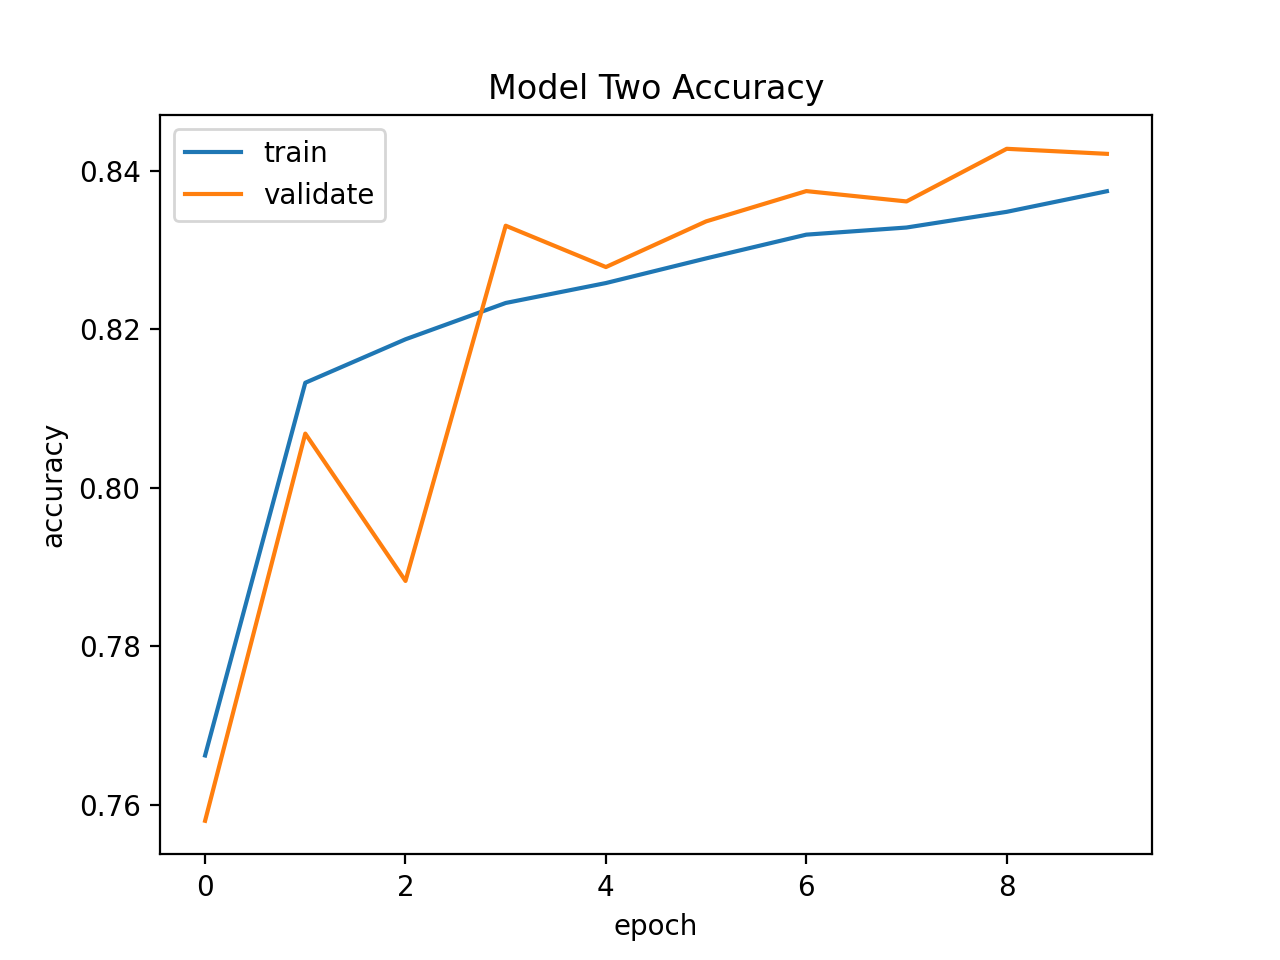

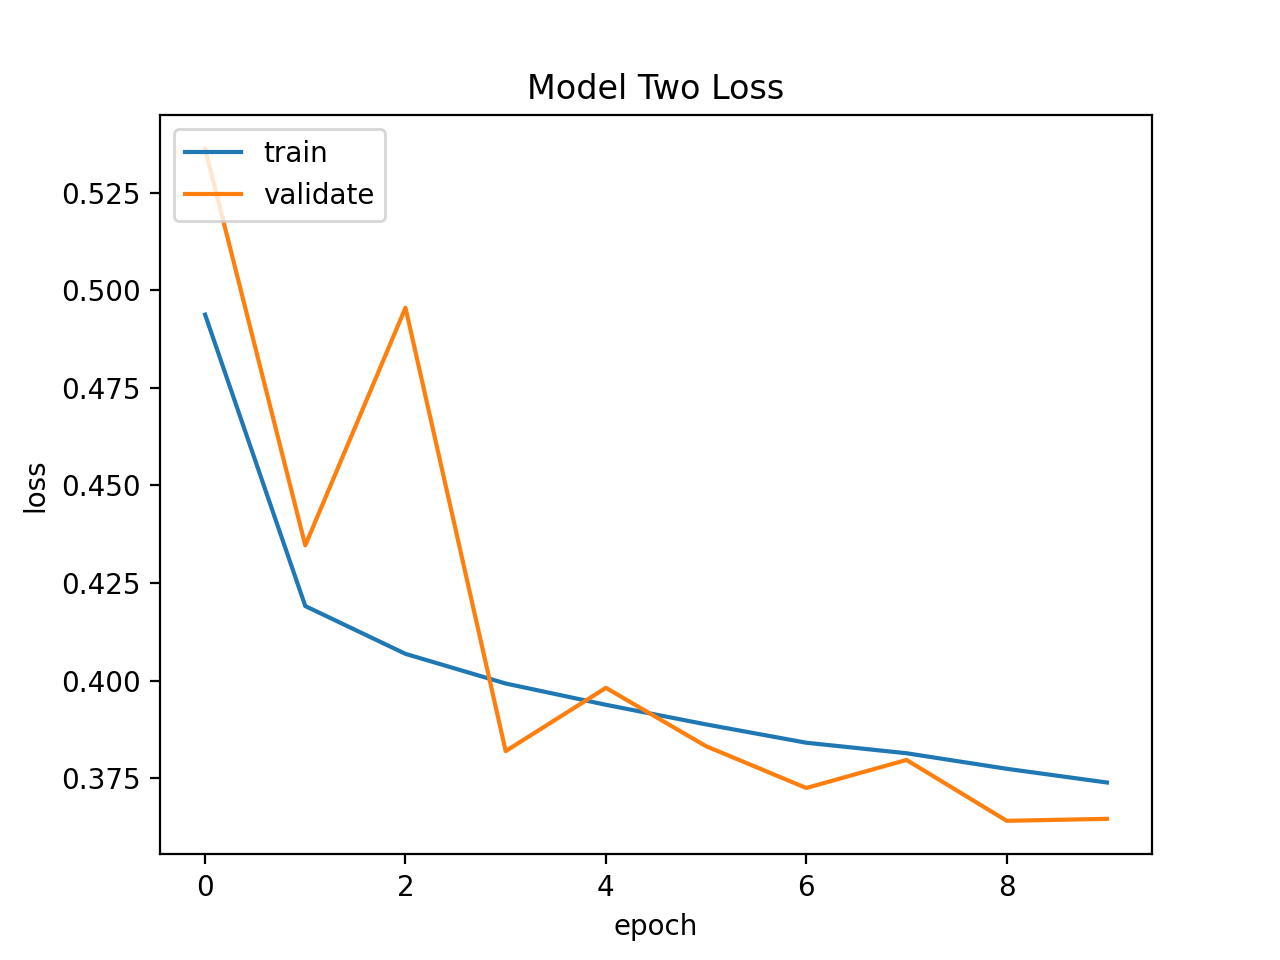

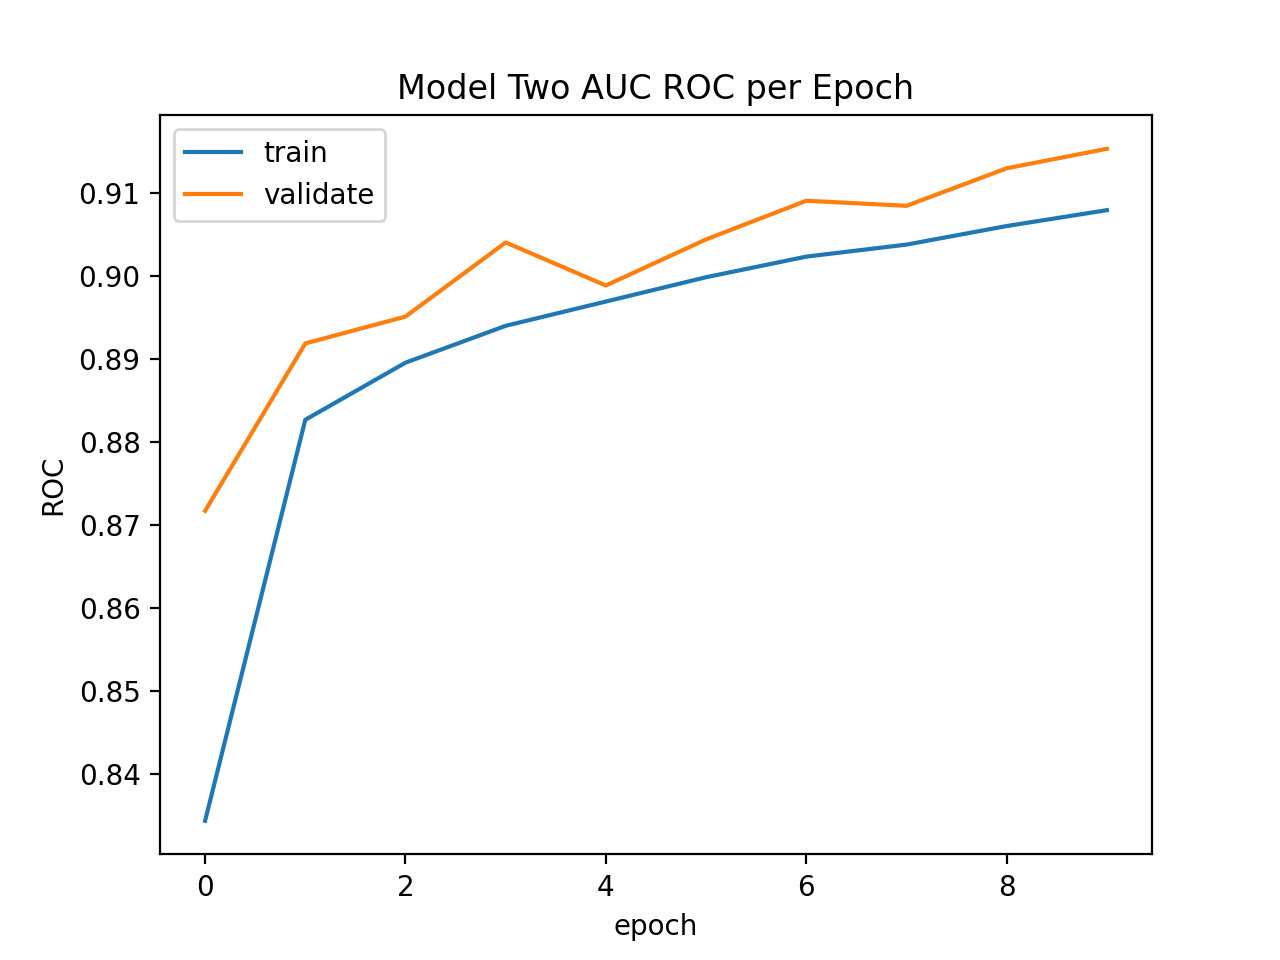

In [59]:
plt.plot(history_model_two.history['accuracy'])
plt.plot(history_model_two.history['val_accuracy'])
plt.title('Model Two Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model_two.history['loss'])
plt.plot(history_model_two.history['val_loss'])
plt.title('Model Two Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model_two.history['auc_1'])
plt.plot(history_model_two.history['val_auc_1'])
plt.title('Model Two AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [27]:
df_test = pd.DataFrame({'id':os.listdir(test_path)})
df_test.head()

id
0  a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif

In [26]:
df_train.head()

id label
139396  d6d79a482c95899c4479696d25bc4a27a3464a13.tif     0
45687   8fedb9f6f82a05ae180e09e17d2dd800fc28abe1.tif     0
191699  745b7ee5af8ba2e7c74c6f6556d166ef321a73ca.tif     0
164877  889d5bfc7eac7bc23fdc367fc7bbc7c82d31108f.tif     0
135510  9db2bb54d49a0fe48c4a90fd07a50e0a3188993e.tif     1

In [73]:
print(df_train['id'].dtype)

object


In [33]:
sample_submission.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [32]:
df_sample_submission = sample_submission.astype(str)
df_sample_submission['id'] +='.tif'

In [70]:
print(df_test['id'].dtype)

object


In [28]:
data_generator_test = ImageDataGenerator(rescale=1./255.)


test_data_generator = data_generator_test.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None
    )

Found 57458 validated image filenames.


In [62]:
test_data_generator_2 = data_generator_test.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col='id', 
    y_col='label',
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [61]:
sample_data = next(test_data_generator)
print("Shape of sample_data:", sample_data.shape)


Shape of sample_data: (1, 64, 64, 3)


In [63]:
sample_data_2 = next(test_data_generator_2)
print("Shape of sample_data:", sample_data.shape)

Shape of sample_data: (1, 64, 64, 3)


In [60]:
sample_data_val = next(validation_data_generator)
print("Shape of sample_data:", sample_data_2[0].shape)

Shape of sample_data: (256, 64, 64, 3)


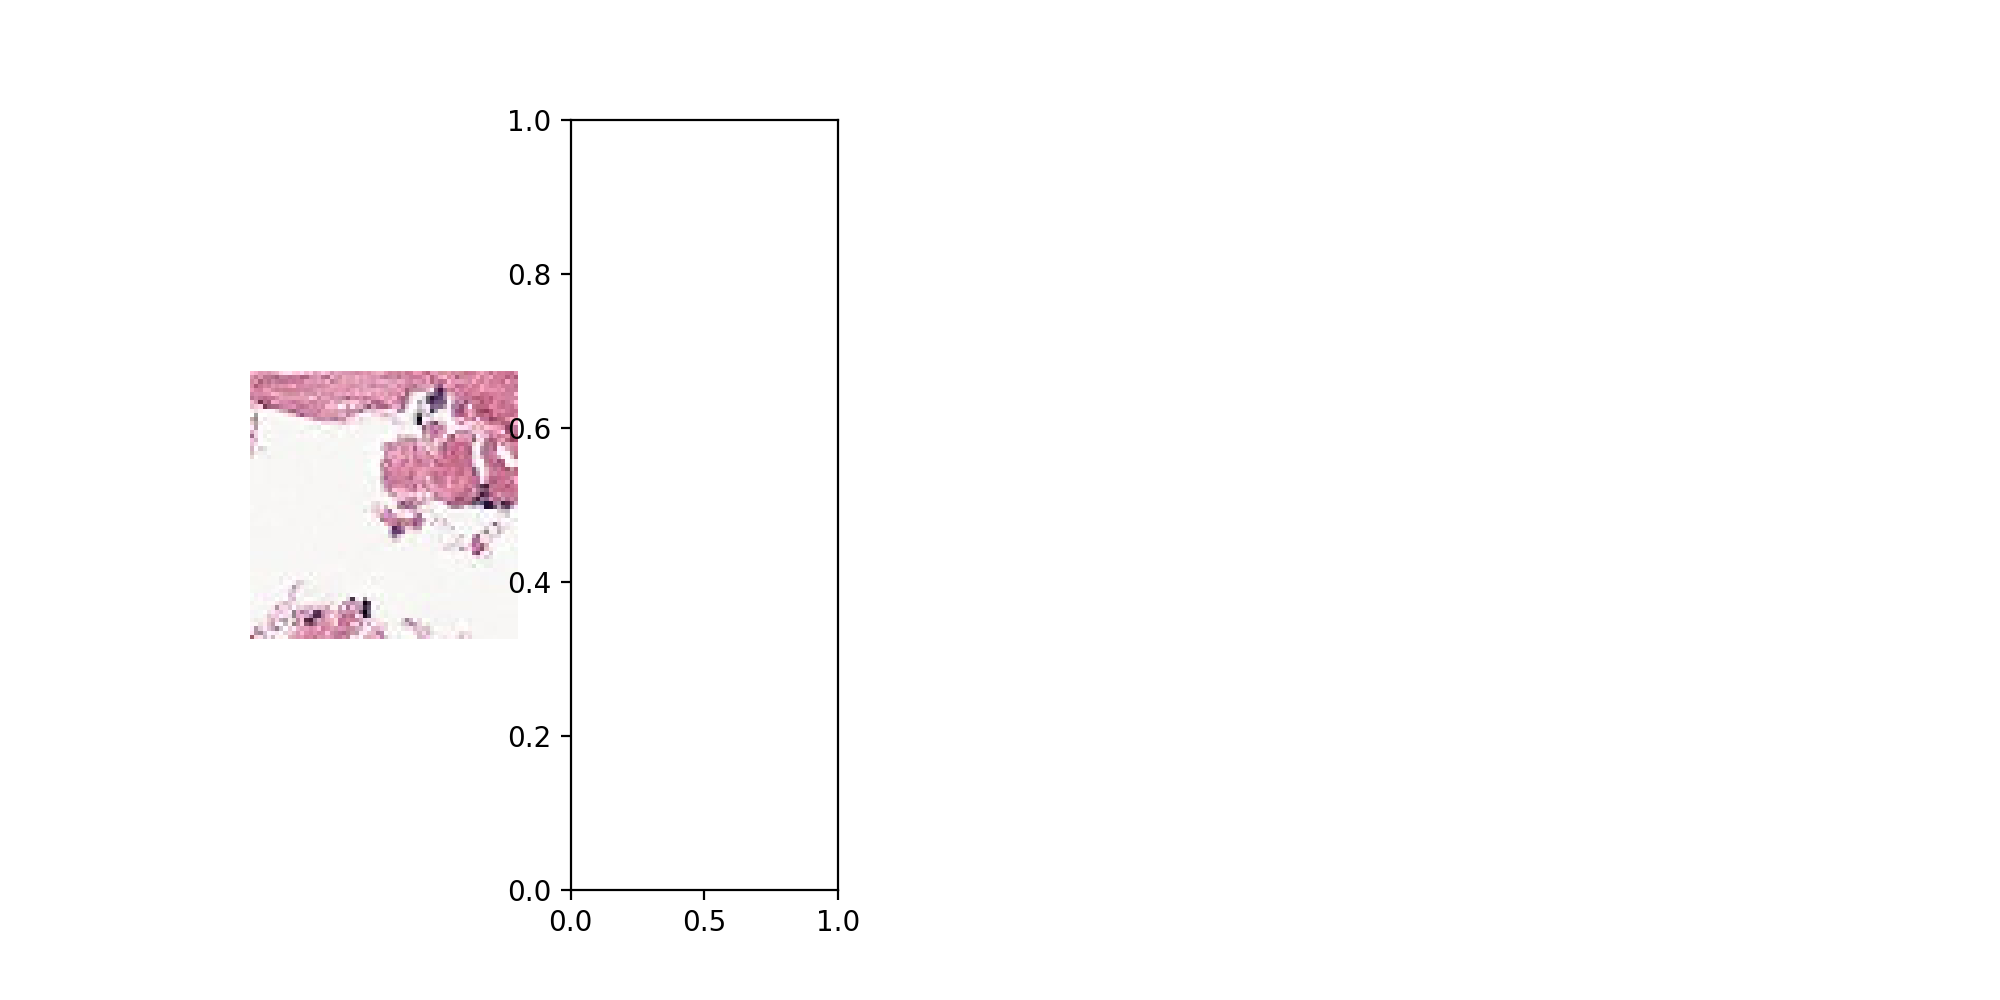

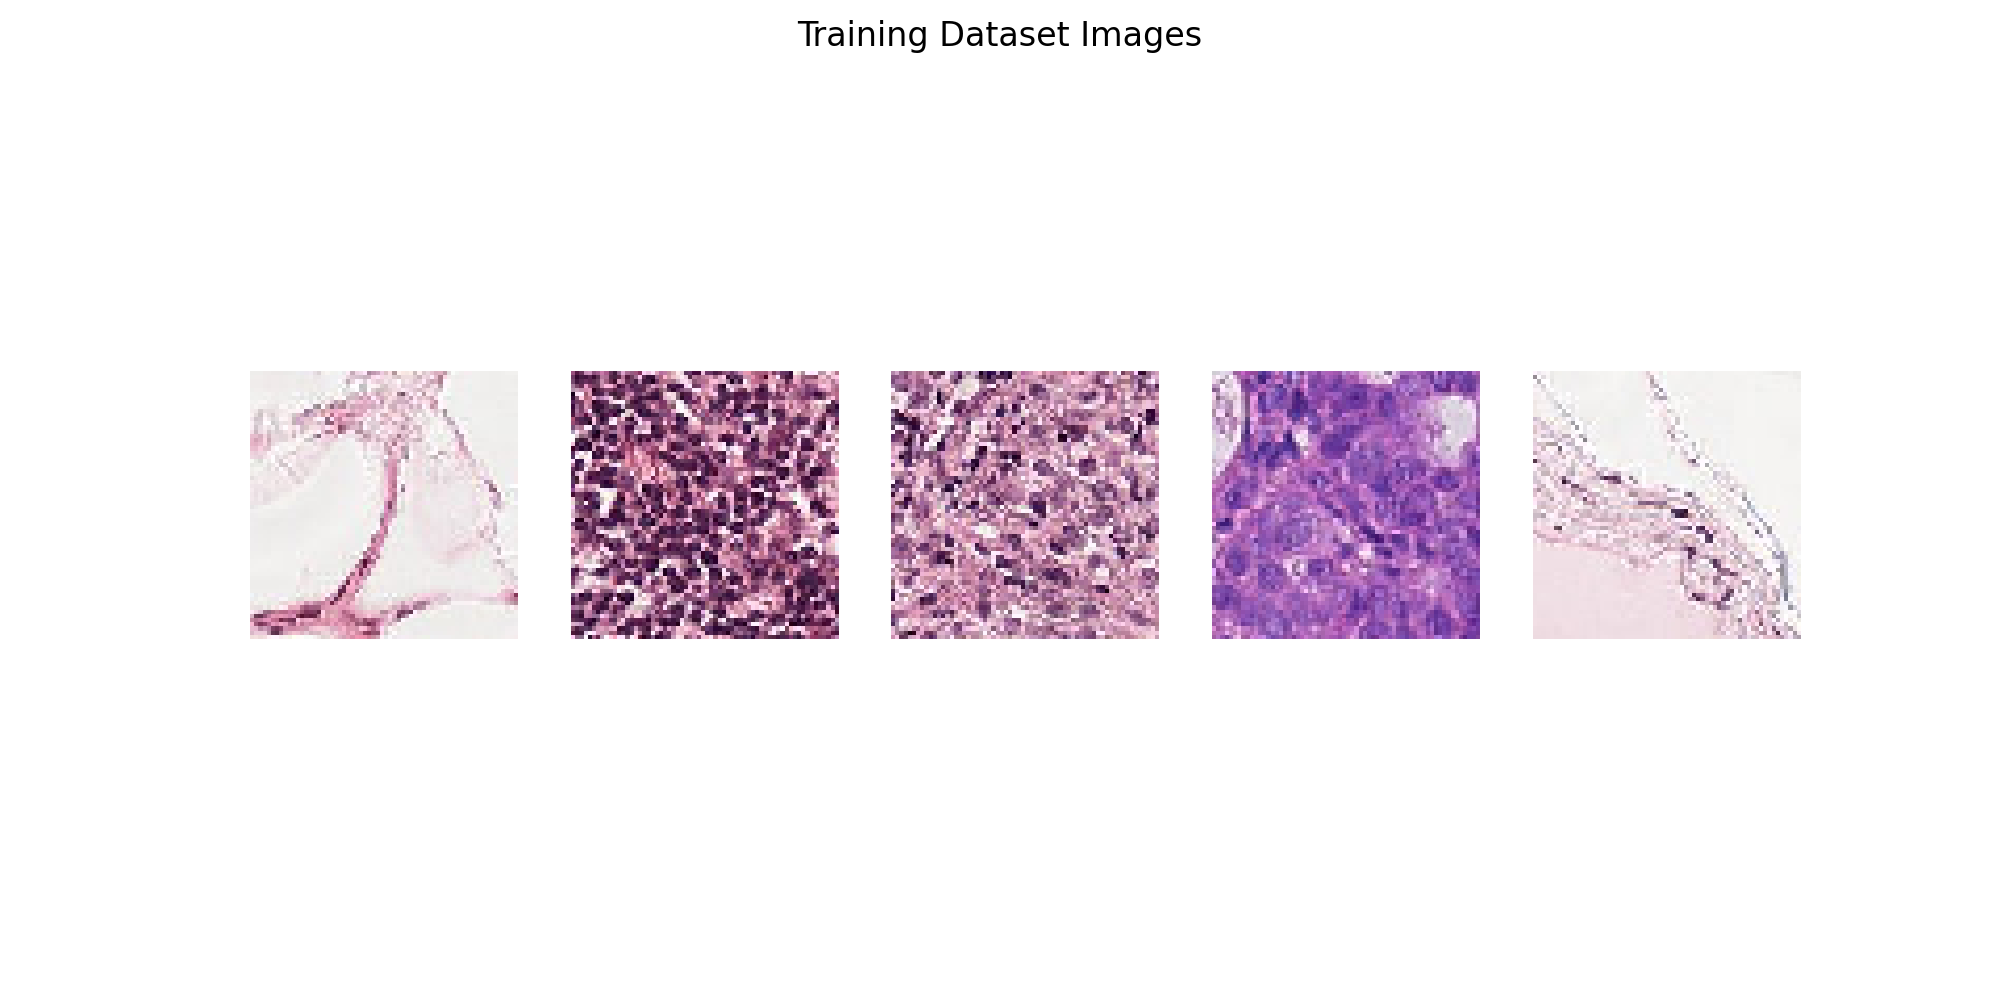

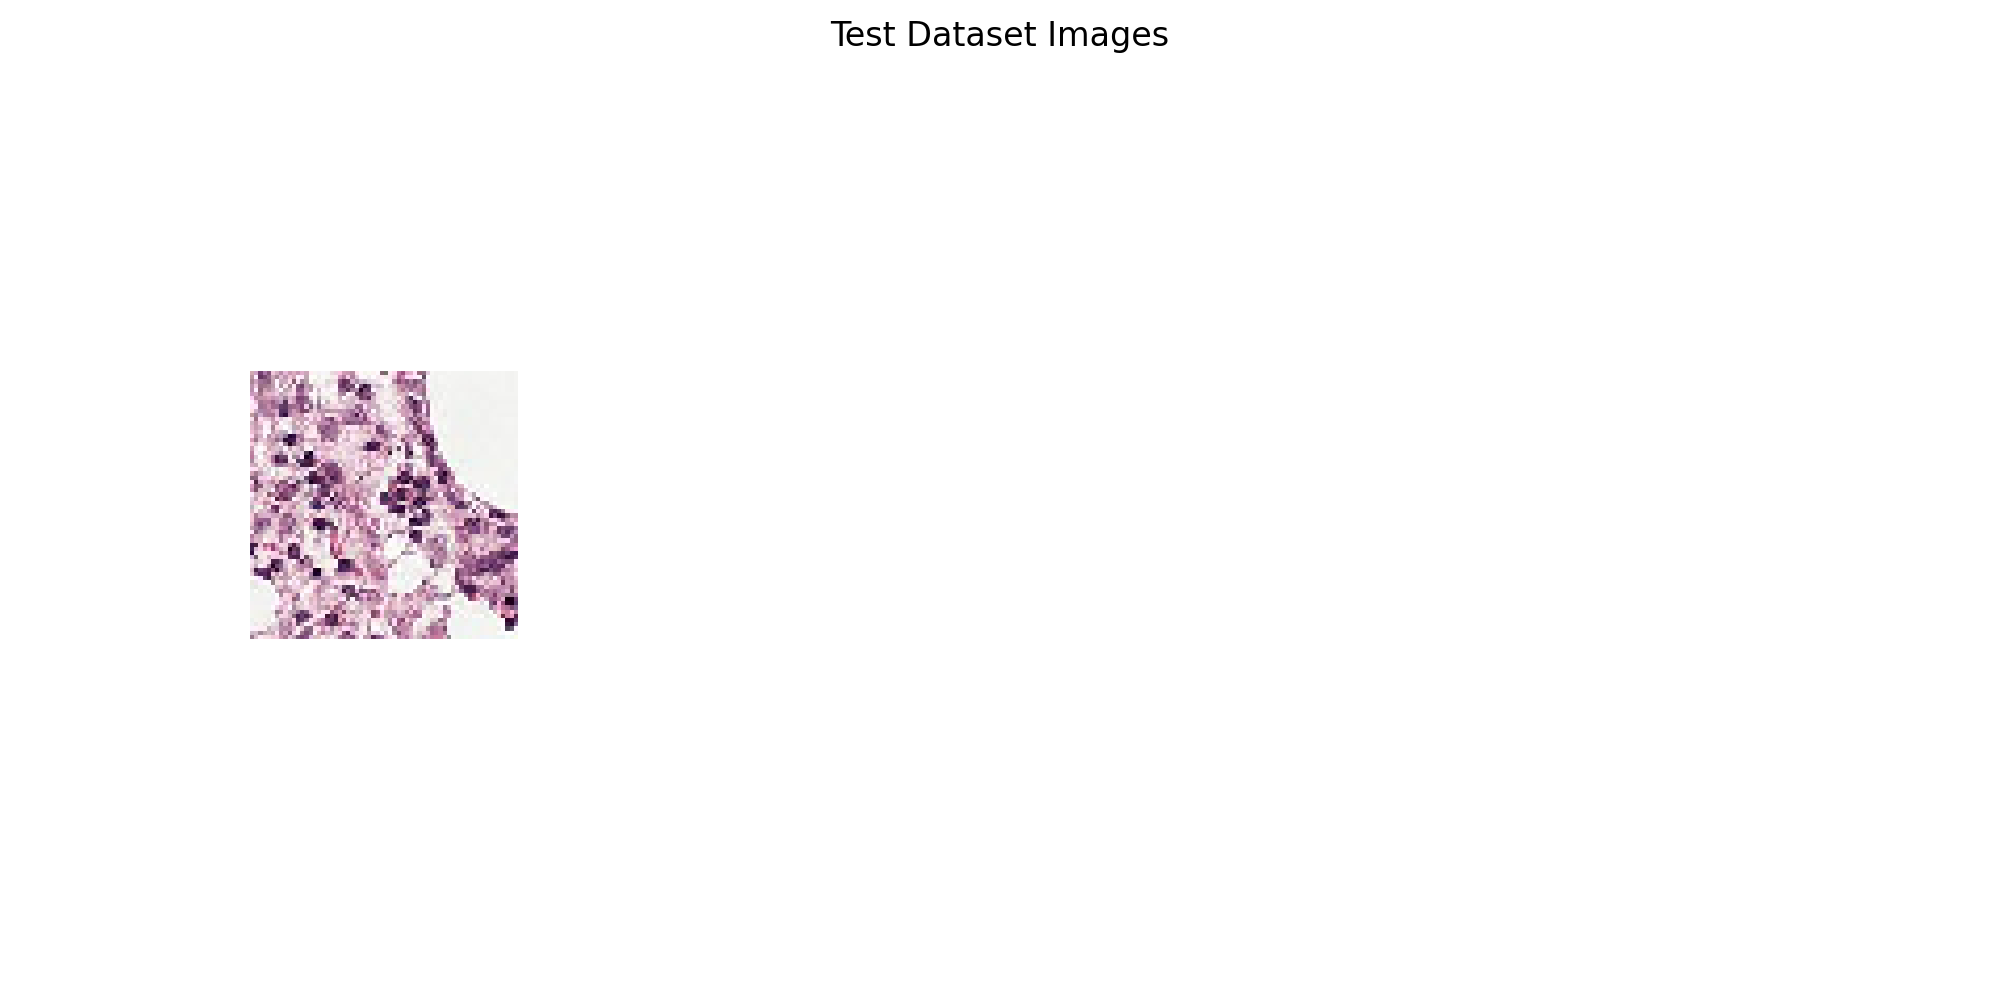

In [69]:

# Display a few randomly selected images from training dataset
sample_images, _ = next(training_data_generator)
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.suptitle('Training Dataset Images')
plt.show()

# Display a few randomly selected images from test dataset
sample_images = next(test_data_generator)
plt.figure(figsize=(10, 5))
for i in range(1):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.suptitle('Test Dataset Images')
plt.show()


In [61]:
model_two.input_shape

(None, None, None, None)

In [56]:
model_one.input_shape

(256, 64, 64, 3)

In [39]:


# Initialize an empty list to store batch shapes
batch_shapes = []

# Iterate over a few batches of data
num_batches_to_check =  1 # You can adjust this number as needed
for _ in range(num_batches_to_check):
    # Generate a batch of data from the generator
    batch_data = next(test_data_generator)
    # Get the shape of the batch and append it to the list
    batch_shapes.append(batch_data.shape)

# Print the shapes of the batches
for i, shape in enumerate(batch_shapes):
    print(f"Shape of batch {i + 1}: {shape}")


Shape of batch 1: (1, 64, 64, 3)


In [47]:
predictions = model_one.predict(test_data_generator, verbose=1)


57458/57458 [==============================] - 157s 3ms/step


In [62]:
predictions_model_2 = model_two.predict(test_data_generator, verbose=1)

57458/57458 [==============================] - 175s 3ms/step


In [50]:
predictions

array([[0.8868282 ],
       [0.43005064],
       [0.5314188 ],
       ...,
       [0.9508359 ],
       [0.13608144],
       [0.3242757 ]], dtype=float32)

In [51]:
predictions_for_submission_1 = np.transpose(predictions)[0]

In [64]:
predictions_for_submission_2 = np.transpose(predictions_model_2)[0]

In [52]:
predictions_for_submission_1

array([0.8868282 , 0.43005064, 0.5314188 , ..., 0.9508359 , 0.13608144,
       0.3242757 ], dtype=float32)

In [36]:
df_submission_1 = pd.DataFrame()

In [67]:
df_submission_2 = pd.DataFrame()

In [40]:
df_submission_1['id'] = df_test['id'].apply(lambda x: x.split('.')[0])

In [68]:
df_submission_2['id'] = df_test['id'].apply(lambda x: x.split('.')[0])

In [53]:
df_submission_1['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

In [69]:
df_submission_2['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions_for_submission_2))

In [54]:
df_submission_1

id  label
0      a7ea26360815d8492433b14cd8318607bcf99d9e      1
1      59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2      5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      1
3      bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4      523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      1
...                                         ...    ...
57453  7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b      0
57454  2a6fc1ed16fa94d263efab330ccbeb1906cbd421      1
57455  6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14      1
57456  f11e7c9e77cbc1ec916a52e6b871a293ee1bb928      0
57457  66d529ceeb28e822fac5e1378cc5702194532127      0

[57458 rows x 2 columns]

In [55]:
df_submission_1['label'].value_counts()

label
1    30619
0    26839
Name: count, dtype: int64

In [56]:
df_submission_1.to_csv('submission.csv', index=False)


## **Step 4: Results and Analysis**

The hyperparameter tuning and difference archictectures for comparison can be seen above with model 1 vs. model 2. Figures for the metrics of each model can also be seen above. Performance improved (via submission score) for the second model. Training with only 10 epochs is not ideal, but given the time constraints, this is what I chose. 

## **Step 5: Conclusion**

The first model was fairly simple with no hyperparameter tuning and performed better than I anticipated but still worse than the second model which utilized hyperparameter tuning. Some key learnings for actually involved tangentially related concepts such as working with TPUs and GPUs in Kaggle notebooks. There are some nuances that come with that and I spent a large amount of time researching and working through those. 

In terms of improving the performace of the models, one improvement that could be implemented in the future is training with more epochs. I chose only 10 because of time constraints, but increasing this could certainly increase performace. Another potential improvement could be doing more image preprocessing. Adding flips, zooms, stretches, and rotations could also improve model performance. And, of course, as always, a final future improvement could just be spending more time tuning hyperparameters (transfer learning is also an option to consider). 

## Link to GitHub repo for project 

[Link to GitHub Repo](https://github.com/bryanpmayfield/dtsa_5511_CNN_Cancer_Detection)

https://github.com/bryanpmayfield/dtsa_5511_CNN_Cancer_Detection